In [69]:
import json, pickle, os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
power_folder = 'output/coref_only_outputs/'
dataset_path = '../narrative_detection/narrative_posts_by_trained_classification.csv'

load all power/agency scores output

In [71]:
with open(power_folder + 'id_persona_power_dict.json') as f:
    id_persona_power_dict = json.load(f)
with open(power_folder + 'id_persona_agency_dict.json') as f:
    id_persona_agency_dict = json.load(f)
with open(power_folder + 'id_persona_total_dict.json') as f:
    id_persona_total_dict = json.load(f)
with open(power_folder + 'id_nsubj_verb_count_dict.pkl', 'rb') as f:
    id_nsubj_verb_count_dict = pickle.load(f)
with open(power_folder + 'id_dobj_verb_count_dict.pkl', 'rb') as f:
    id_dobj_verb_count_dict = pickle.load(f)
with open(power_folder + 'id_persona_score_dict.json') as f:
    id_persona_power_score_dict = json.load(f)
with open(power_folder + 'id_persona_agency_score_dict.json') as f:
    id_persona_agency_score_dict = json.load(f)
with open(power_folder + 'id_persona_total_dict.json', 'r') as f:
    id_persona_total_dict = json.load(f)

compute scores per subreddit

In [72]:
dataset = pd.read_csv(dataset_path)
subreddit_list = dataset['subreddit'].unique().tolist()
all_texts = dataset['selftext'].tolist()
all_subs = dataset['subreddit'].tolist()

In [74]:
for sub in subreddit_list:
    # Get all texts from this subreddit
    indicies = [i for i, x in enumerate(all_subs) if x == sub]
    texts = [all_texts[i] for i in indicies]

    # Get all power and agency scores per text, per persona in this subreddit
    sub_id_persona_power_dict = {str(i): id_persona_power_dict[str(i)] for i in indicies if str(i) in id_persona_power_dict}
    sub_id_persona_agency_dict = {str(i): id_persona_agency_dict[str(i)] for i in indicies if str(i) in id_persona_agency_dict}
    sub_id_persona_power_score_dict = {str(i): id_persona_power_score_dict[str(i)] for i in indicies if str(i) in id_persona_power_score_dict}
    sub_id_persona_agency_score_dict = {str(i): id_persona_agency_score_dict[str(i)] for i in indicies if str(i) in id_persona_agency_score_dict}
    sub_id_persona_counts_total_dict = {str(i): id_persona_total_dict[str(i)] for i in indicies if str(i) in id_persona_total_dict}

    # Get persona counts in this subreddit
    persona_counts_power = defaultdict(int)
    for _id, _persona_power_dict in sub_id_persona_power_dict.items():
        for _persona in _persona_power_dict.keys():
            #persona_counts_power[_persona] += _persona_power_dict[_persona]['positive'] + _persona_power_dict[_persona]['negative']
            if 'positive' in _persona_power_dict[_persona]:
                persona_counts_power[_persona] += _persona_power_dict[_persona]['positive']
            if 'negative' in _persona_power_dict[_persona]:
                persona_counts_power[_persona] += _persona_power_dict[_persona]['negative']

    persona_counts_agency = defaultdict(int)
    for _id, _persona_agency_dict in sub_id_persona_agency_dict.items():
        for _persona in _persona_agency_dict.keys():
            #persona_counts_agency[_persona] += _persona_agency_dict[_persona]['positive'] + _persona_agency_dict[_persona]['negative']
            if 'positive' in _persona_agency_dict[_persona]:
                persona_counts_agency[_persona] += _persona_agency_dict[_persona]['positive']
            if 'negative' in _persona_agency_dict[_persona]:
                persona_counts_agency[_persona] += _persona_agency_dict[_persona]['negative']

    persona_counts_total = defaultdict(int)
    for _id, _persona_total_dict in sub_id_persona_counts_total_dict.items():
        for _persona in _persona_total_dict.keys():
            persona_counts_total[_persona] += _persona_total_dict[_persona]

    # Get average power and agency scores per persona in this subreddit
    persona_power_scores_dict = defaultdict(list)
    for _id, _persona_score_dict in sub_id_persona_power_score_dict.items():
        for _persona, _score in _persona_score_dict.items():
            persona_power_scores_dict[_persona].append(_score)
    persona_power_score_dict = {_persona: np.mean(_scores) for _persona, _scores in persona_power_scores_dict.items()}

    persona_agency_scores_dict = defaultdict(list)
    for _id, _persona_agency_score_dict in sub_id_persona_agency_score_dict.items():
        for _persona, _score in _persona_agency_score_dict.items():
            persona_agency_scores_dict[_persona].append(_score)
    persona_agency_score_dict = {_persona: np.mean(_scores) for _persona, _scores in persona_agency_scores_dict.items()}

    # Save to file
    save_folder = power_folder + sub + '/'
    if not os.path.exists(save_folder):
        os.makedirs(save_folder)
    with open(save_folder + 'persona_power_score_dict.json', 'w') as f:
        json.dump(persona_power_score_dict, f, indent=4)
    with open(save_folder + 'persona_agency_score_dict.json', 'w') as f:
        json.dump(persona_agency_score_dict, f, indent=4)
    with open(save_folder + 'persona_counts_power.json', 'w') as f:
        json.dump(persona_counts_power, f, indent=4)
    with open(save_folder + 'persona_counts_agency.json', 'w') as f:
        json.dump(persona_counts_agency, f, indent=4)
    with open(save_folder + 'persona_counts_total.json', 'w') as f:
        json.dump(persona_counts_total, f, indent=4)


charts of persona power/agency per subreddit

In [76]:
power_across_subs = {}
agency_across_subs = {}

power_counts = defaultdict(dict)
agency_counts = defaultdict(dict)
total_counts = defaultdict(dict)

for sub in subreddit_list:
    with open(power_folder + sub + '/persona_power_score_dict.json') as f:
        persona_power_score_dict = json.load(f)
    with open(power_folder + sub + '/persona_agency_score_dict.json') as f:
        persona_agency_score_dict = json.load(f)
    with open(power_folder + sub + '/persona_counts_power.json') as f:
        persona_counts_power = json.load(f)
    with open(power_folder + sub + '/persona_counts_agency.json') as f:
        persona_counts_agency = json.load(f)
    with open(power_folder + sub + '/persona_counts_total.json') as f:
        persona_counts_total = json.load(f)
    
    for persona, power_score in persona_power_score_dict.items():
        if persona not in power_across_subs:
            power_across_subs[persona] = {}
        power_across_subs[persona][sub] = power_score
        power_counts[persona][sub] = persona_counts_power[persona] if persona in persona_counts_power else 0
    
    for persona, agency_score in persona_agency_score_dict.items():
        if persona not in agency_across_subs:
            agency_across_subs[persona] = {}
        agency_across_subs[persona][sub] = agency_score
        agency_counts[persona][sub] = persona_counts_agency[persona] if persona in persona_counts_agency else 0

    total_counts[sub] = persona_counts_total

In [77]:
power_across_subs_df = pd.DataFrame.from_dict(power_across_subs).T
power_counts_df = pd.DataFrame.from_dict(power_counts).T
power_counts_df.fillna(0, inplace=True)

agency_across_subs_df = pd.DataFrame.from_dict(agency_across_subs).T

total_counts_df = pd.DataFrame.from_dict(total_counts)
total_counts_df.fillna(0, inplace=True)

In [78]:
agency_across_subs_df

,EatingDisorders,eating_disorders,EatingDisorderHope,edsupport,EDAnonymous,EdAnonymousAdults,EDRecovery_public,AnorexiaNervosa,AnorexiaRecovery,bulimia,BulimiaAndAnaSupport,BingeEatingDisorder,bingeeating,anorexiaflareuphelp,BulimiaRecovery,PurgingDisorder,NotOtherwiseSpecified
food,0.210362,0.391208,0.200000,0.111111,0.282612,0.298798,0.201358,0.300175,0.273284,0.277750,0.111111,0.103704,0.351515,NaN,NaN,NaN,NaN
therapist,0.495370,0.329787,1.000000,0.200000,0.324921,0.449467,-0.466667,0.270833,0.558333,0.063519,0.750000,0.833333,1.000000,NaN,NaN,NaN,NaN
medical_prof,0.319401,0.403242,1.000000,0.777778,0.312187,0.451027,0.006944,0.469824,0.481507,0.296814,0.666667,0.723333,0.666667,1.000000,NaN,NaN,NaN
reader,0.138635,0.117862,-0.308036,0.019728,0.121144,0.099189,0.132141,0.148045,0.176655,0.152115,0.031566,0.100081,0.128677,-0.033333,1.000000,0.00,NaN
narrator,0.135586,0.156567,-0.009125,0.137037,0.160706,0.153486,0.109508,0.112984,0.148617,0.119524,0.023140,0.188852,0.125699,0.279167,0.253968,0.25,1.0
ex_SO,0.414822,0.437217,0.750000,0.500000,0.466964,0.317065,0.305556,0.473871,0.458035,0.227824,0.500000,0.055556,0.833333,NaN,NaN,NaN,NaN
family,0.385457,0.355158,0.546154,0.500000,0.373243,0.311979,0.294006,0.395048,0.310390,0.296787,-0.183333,0.528534,0.397436,0.261905,NaN,NaN,NaN
SO_female,0.085080,-0.017956,0.500000,0.351190,0.009547,-0.023810,0.000000,0.085778,0.353309,0.127886,NaN,0.500000,-1.000000,NaN,NaN,NaN,NaN
SO_any,0.134333,0.298024,0.636574,0.351190,0.347332,0.269004,0.318681,0.316762,0.360328,0.209043,NaN,0.308333,0.000000,NaN,NaN,NaN,NaN
friend,0.198682,0.346968,0.797619,-0.041667,0.335057,0.378216,0.276576,0.293225,0.204361,0.178455,0.000000,0.142857,0.458333,NaN,NaN,NaN,NaN


In [79]:
power_across_subs_df

,EatingDisorders,eating_disorders,EatingDisorderHope,edsupport,EDAnonymous,EdAnonymousAdults,EDRecovery_public,AnorexiaNervosa,AnorexiaRecovery,anorexiaflareuphelp,bulimia,BulimiaRecovery,BulimiaAndAnaSupport,BingeEatingDisorder,bingeeating,PurgingDisorder,NotOtherwiseSpecified
food,-0.644482,-0.670880,-0.876190,-0.600000,-0.609008,-0.622682,-0.636753,-5.298057e-01,-0.581149,-0.500000,-0.600787,-1.000000,-0.767094,-0.589044,-0.667398,-1.000000,NaN
therapist,-0.049333,-0.167754,NaN,0.400000,-0.084615,-0.126984,0.555556,-1.009294e-17,-0.011979,NaN,-0.202183,NaN,NaN,-0.500000,NaN,NaN,NaN
medical_prof,-0.002114,-0.132259,-0.333333,-0.129630,-0.167848,-0.167895,0.391667,6.517165e-02,0.083585,1.000000,-0.208398,NaN,-0.666667,0.048148,-0.770833,NaN,NaN
narrator,-0.321116,-0.314795,-0.395965,-0.199537,-0.315231,-0.335930,-0.264194,-3.234178e-01,-0.311133,-0.140000,-0.342187,-0.329524,-0.434776,-0.130994,-0.265061,-0.083333,1.0
reader,0.519290,0.485281,-0.250000,0.138988,0.393971,0.372570,0.393916,3.505662e-01,0.486103,0.186667,0.358430,0.666667,0.282986,0.321058,0.257924,1.000000,NaN
ex_SO,-0.591506,-0.551678,-0.300000,-0.416667,-0.521892,-0.572989,-0.693548,-4.750000e-01,-0.413577,NaN,-0.648754,-1.000000,-0.875000,-0.384615,-0.722222,-1.000000,NaN
family,0.142490,0.130177,0.584524,-0.291667,0.115236,-0.037486,-0.047795,2.598106e-01,0.038098,-0.035714,0.035794,NaN,-0.310417,0.394237,0.098039,NaN,NaN
SO_female,0.097669,0.243194,0.500000,0.659226,0.105722,-0.230159,-1.000000,1.609709e-01,0.234283,NaN,-0.090188,NaN,NaN,0.750000,NaN,NaN,NaN
SO_any,-0.030058,0.159267,0.185185,0.659226,0.230215,0.083909,-0.303114,4.731850e-03,0.304542,NaN,0.203778,NaN,NaN,0.511111,-1.000000,NaN,NaN
friend,0.152381,0.038927,0.000000,0.569444,0.031633,-0.185989,0.038395,3.420503e-02,-0.021241,NaN,-0.066558,NaN,1.000000,0.121212,-0.033333,NaN,NaN


In [80]:
# reorder and remove some columns
power_general_subs = power_across_subs_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
power_recover_subs = power_across_subs_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
power_across_subs_df = pd.concat([power_general_subs, power_recover_subs], axis=1)

# same for agency
agency_general_subs = agency_across_subs_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
agency_recover_subs = agency_across_subs_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
agency_across_subs_df = pd.concat([agency_general_subs, agency_recover_subs], axis=1)

# same for counts df
power_general_counts = power_counts_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
power_recover_counts = power_counts_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
power_counts_df = pd.concat([power_general_counts, power_recover_counts], axis=1)
power_counts_df = power_counts_df.astype(int)

# same for total counts df
total_general_counts = total_counts_df[['EatingDisorders', 'eating_disorders', 'AnorexiaNervosa', 'anorexiaflareuphelp', 'bulimia', 'BingeEatingDisorder', 'bingeeating']]
total_recover_counts = total_counts_df[['EatingDisorderHope', 'edsupport', 'EDAnonymous', 'EdAnonymousAdults', 'EDRecovery_public', 'AnorexiaRecovery', 'BulimiaRecovery','BulimiaAndAnaSupport']]
total_counts_df = pd.concat([total_general_counts, total_recover_counts], axis=1)
total_counts_df = total_counts_df.astype(int)

In [81]:
total_counts_df 

,EatingDisorders,eating_disorders,AnorexiaNervosa,anorexiaflareuphelp,bulimia,BingeEatingDisorder,bingeeating,EatingDisorderHope,edsupport,EDAnonymous,EdAnonymousAdults,EDRecovery_public,AnorexiaRecovery,BulimiaRecovery,BulimiaAndAnaSupport
food,713,1543,319,2,555,183,133,30,23,1081,1312,192,926,6,49
therapist,65,156,38,0,92,6,6,3,5,86,245,10,87,0,3
medical_prof,270,433,135,1,234,46,24,7,17,341,701,43,307,0,11
narrator,1990,4557,1257,15,2122,439,312,133,73,3839,5147,664,3139,22,87
reader,477,1108,324,15,611,201,169,28,87,1102,1460,215,1194,5,53
SO_male,151,373,65,0,139,13,6,30,0,224,557,29,122,0,1
SO_any,484,615,161,0,243,24,8,35,33,386,808,36,377,0,1
friend,723,1058,229,0,309,26,12,30,29,534,622,79,538,0,4
ED,256,591,128,1,376,84,64,15,23,379,486,75,313,2,13
ex_SO,183,388,161,0,175,21,17,10,9,338,510,51,476,1,8


In [82]:
power_across_subs_df

,EatingDisorders,eating_disorders,AnorexiaNervosa,anorexiaflareuphelp,bulimia,BingeEatingDisorder,bingeeating,EatingDisorderHope,edsupport,EDAnonymous,EdAnonymousAdults,EDRecovery_public,AnorexiaRecovery,BulimiaRecovery,BulimiaAndAnaSupport
food,-0.644482,-0.670880,-5.298057e-01,-0.500000,-0.600787,-0.589044,-0.667398,-0.876190,-0.600000,-0.609008,-0.622682,-0.636753,-0.581149,-1.000000,-0.767094
therapist,-0.049333,-0.167754,-1.009294e-17,NaN,-0.202183,-0.500000,NaN,NaN,0.400000,-0.084615,-0.126984,0.555556,-0.011979,NaN,NaN
medical_prof,-0.002114,-0.132259,6.517165e-02,1.000000,-0.208398,0.048148,-0.770833,-0.333333,-0.129630,-0.167848,-0.167895,0.391667,0.083585,NaN,-0.666667
narrator,-0.321116,-0.314795,-3.234178e-01,-0.140000,-0.342187,-0.130994,-0.265061,-0.395965,-0.199537,-0.315231,-0.335930,-0.264194,-0.311133,-0.329524,-0.434776
reader,0.519290,0.485281,3.505662e-01,0.186667,0.358430,0.321058,0.257924,-0.250000,0.138988,0.393971,0.372570,0.393916,0.486103,0.666667,0.282986
ex_SO,-0.591506,-0.551678,-4.750000e-01,NaN,-0.648754,-0.384615,-0.722222,-0.300000,-0.416667,-0.521892,-0.572989,-0.693548,-0.413577,-1.000000,-0.875000
family,0.142490,0.130177,2.598106e-01,-0.035714,0.035794,0.394237,0.098039,0.584524,-0.291667,0.115236,-0.037486,-0.047795,0.038098,NaN,-0.310417
SO_female,0.097669,0.243194,1.609709e-01,NaN,-0.090188,0.750000,NaN,0.500000,0.659226,0.105722,-0.230159,-1.000000,0.234283,NaN,NaN
SO_any,-0.030058,0.159267,4.731850e-03,NaN,0.203778,0.511111,-1.000000,0.185185,0.659226,0.230215,0.083909,-0.303114,0.304542,NaN,NaN
friend,0.152381,0.038927,3.420503e-02,NaN,-0.066558,0.121212,-0.033333,0.000000,0.569444,0.031633,-0.185989,0.038395,-0.021241,NaN,1.000000


In [83]:
# make chart for each persona and save to file
for persona in power_across_subs_df.index:
    persona_data = power_across_subs_df.loc[persona]
    persona_counts = total_counts_df.loc[persona]

    sns.barplot(x=persona_data.index, y=persona_data.values)
    plt.title('Average power scores for ' + persona)
    plt.xlabel('Subreddit')
    plt.ylabel('Average power score')
    plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
    plt.xticks(rotation=90)

    save_dir = power_folder + 'figs/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(save_dir + 'power_' + persona + '.png', bbox_inches='tight')

    # clear figure
    plt.clf()

# same but for agency
for persona in agency_across_subs_df.index:
    persona_data = agency_across_subs_df.loc[persona]
    persona_counts = total_counts_df.loc[persona]

    sns.barplot(x=persona_data.index, y=persona_data.values)
    plt.title('Average agency scores for ' + persona)
    plt.xlabel('Subreddit')
    plt.ylabel('Average agency score')
    plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
    plt.xticks(rotation=90)

    save_dir = power_folder + 'figs/'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(save_dir + 'agency_' + persona + '.png', bbox_inches='tight')

    # clear figure
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [84]:
persona_counts_agency

{'narrator': 1}

In [85]:
with open(power_folder + 'persona_power_score_dict.json', 'r') as f:
    persona_power_score_dict = json.load(f)
with open(power_folder + 'persona_agency_score_dict.json', 'r') as f:
    persona_agency_score_dict = json.load(f)
with open(power_folder + 'persona_counts_power.json', 'r') as f:
    persona_counts_power = json.load(f)
with open(power_folder + 'persona_counts_agency.json', 'r') as f:
    persona_counts_agency = json.load(f)

In [86]:
# general power/agency chart across all subs (not per sub)
persona_power_score_df = pd.DataFrame.from_dict(persona_power_score_dict, orient='index').T
persona_agency_score_df = pd.DataFrame.from_dict(persona_agency_score_dict, orient='index').T
persona_counts_power_df = pd.DataFrame.from_dict(persona_counts_power, orient='index').T
persona_counts_agency_df = pd.DataFrame.from_dict(persona_counts_agency, orient='index').T

# reorder columns
persona_power_score_df = persona_power_score_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_agency_score_df = persona_agency_score_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_counts_power_df = persona_counts_power_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]
persona_counts_agency_df = persona_counts_agency_df[['narrator', 'reader', 'medical_prof', 'friend', 'family', 'SO_any', 'ex_SO', 'food', 'ED']]

In [87]:
# make chart for power
sns.barplot(data=persona_power_score_df, palette='hls')
plt.title('Average power scores for all personas')
plt.xlabel('Persona')
plt.ylabel('Average power score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts_power_df.values[0])
plt.xticks(rotation=90)

save_dir = power_folder + 'figs/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(save_dir + 'power_ALL.png', bbox_inches='tight')

# clear figure
plt.clf()

# same but for agency
sns.barplot(data=persona_agency_score_df, palette='hls')
plt.title('Average agency scores for all personas')
plt.xlabel('Persona')
plt.ylabel('Average agency score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts_agency_df.values[0])
plt.xticks(rotation=90)

plt.savefig(save_dir + 'agency_ALL.png', bbox_inches='tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [88]:
persona_power_score_df

,narrator,reader,medical_prof,friend,family,SO_any,ex_SO,food,ED
0,-0.317651,0.416788,-0.102756,-0.004127,0.083128,0.143304,-0.538637,-0.623483,-0.581554


In [89]:
persona_data = power_across_subs_df.loc['family']
persona_counts = total_counts_df.loc['family']

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'EatingDisorders'),
  Text(1, 0, 'eating_disorders'),
  Text(2, 0, 'AnorexiaNervosa'),
  Text(3, 0, 'anorexiaflareuphelp'),
  Text(4, 0, 'bulimia'),
  Text(5, 0, 'BingeEatingDisorder'),
  Text(6, 0, 'bingeeating'),
  Text(7, 0, 'EatingDisorderHope'),
  Text(8, 0, 'edsupport'),
  Text(9, 0, 'EDAnonymous'),
  Text(10, 0, 'EdAnonymousAdults'),
  Text(11, 0, 'EDRecovery_public'),
  Text(12, 0, 'AnorexiaRecovery'),
  Text(13, 0, 'BulimiaRecovery'),
  Text(14, 0, 'BulimiaAndAnaSupport')])

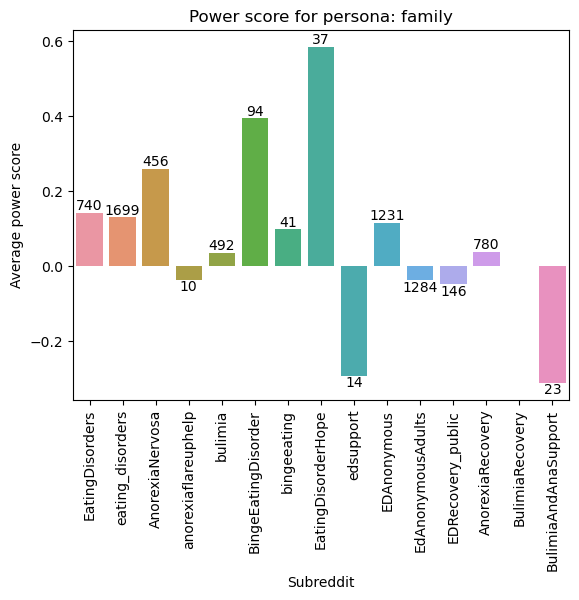

In [90]:
sns.barplot(x=persona_data.index, y=persona_data.values)
plt.title('Power score for persona: family')
plt.xlabel('Subreddit')
plt.ylabel('Average power score')
plt.bar_label(plt.gca().containers[0], fmt='%.2f', labels=persona_counts.values)
plt.xticks(rotation=90)